# Randomized Optimization Algorithms

## Introduction

In the previous assighnment we analysed various supervised algorithms, which were all solving some optimization problem in the form of minimizing the derivative of the error. What if the derivative does not exists, like in discrete problems which are not defined on continuous functions? Since discrete functions cannot be differentiated, then gradient descent tool cannot be used.
Here we turn towards search and various way of optimizing it using randomized optimization algorithms. 

## Finding weights for ANN

In this section I will use optimization algorithms to search for the best weights in the Neural Network classification on the problem of Higgs detection from the previous assignment.

Quick review:

   - given outcomes of particle decays, detect Higgs boson; 
   
   - most of the supervised algorithms gave acceptable accuracy ranging from 0.8 - 0.9;
   
   - neural network gave the worse accuracy of around 0.5 (50%) across all expreriments with tunning paramaters;
    
Since backpropagation algorithm in the neural network did not provide satisfactory accuracy on the higgs dataset, the problem is higgs detection becomes a great candidate to apply randomized optimization algorithms weights learning.

From the previous assignment it was concluded that dataset size of 20k records will suffice the experiment while saving running time significantly:

In [1]:
%matplotlib inline

In [2]:
from algo_evaluation.datasets import *
from algo_evaluation.supervised import neural_network as nn

In [3]:
higgs_data = load_higgs_train(sample_size=20000)
features, weights, labels = higgs_data
print 'Size of the dataset:', features.shape[0]
print 'Number of features:', features.shape[1]
print 'Number of positives (signal):', labels.value_counts()['s']
print 'Number of negatives (background):', labels.value_counts()['b']

Size of the dataset: 5477
Number of features: 13
Number of positives (signal): 2525
Number of negatives (background): 2952


Learning weights for the neural network will be achieved using pybrain library (same as in the previous assignment). 

The __cost function__ here (called evaluator) will be __MSE__ (mean squared error) and the goal is to minimize it using three different optimization algorithms: RandomizedHillClimber, Genetic Algorithm and Simulated Anealing.

__Fitness function__ would required maximization of __-MSE__

In [4]:
df_nn = nn.compare_weight_learning_optimized(higgs_data)

__Accuracy Comparison across algorithms for Higgs Dataset__

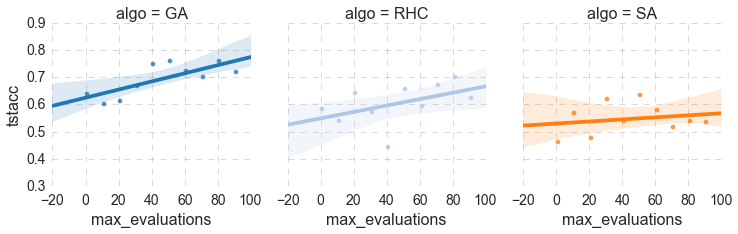

In [5]:
nn.plot_weight_learning_accuracy(df_nn)

Overall, comparing to Backpropagation algorithm, learning weights by means of randomized optimization algorithms performed __significantly__ beter (every single algoritm bit the baseline from the previous analysis)
I fitted the regression line through the accuracy points to be able to see the trends easier since algorithms did not reach stability due to limited number of iterations.

Genetic Algorithm gave the highest accuracy reaching 0.8 as compared to maximum of 0.5 using Backpropagation algorithm. Accuracy trending for both, Genetic Algorithm and Hill Climber, is upwords which shows that they kept improving at each iteration. In contrast, variance of the accuracy for Simulated Annealing is quite high (shaded areas around the trending line) which demonstrated the nature of the algorithm as it accepts worse solutions when some conditions apply. In theory, if I would to let it run for more iterations, it might give better results, however for the purpose of contrasting performance of algorithms for Higgs dataset, constant number of iterations is desirable.

__Training and Prediction Time comparison across algorithms for Higgs Dataset__

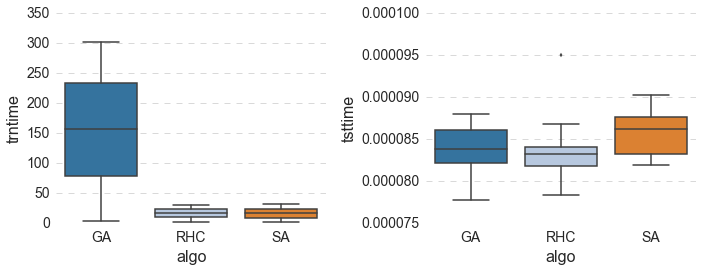

In [6]:
nn.plot_weight_learning_time(df_nn)

Genetic Algorithm gave the best accuracy score, however it took the longest time to learn the weights for the neural network since generating new offspring can be costly as compared to simpler function evaluations for hill climber and simulated annealing.

For visualizing the prediction time for observations (outcomes of particle colisions), I used the average time per record as opposed to prediction time for all records (since total prediction time could be outweighted by the number of observations)
Thus, prediction times across all algorithms is comparable as it should be, because once the weights have been learned, there is no dependence on the algorithm anymore.

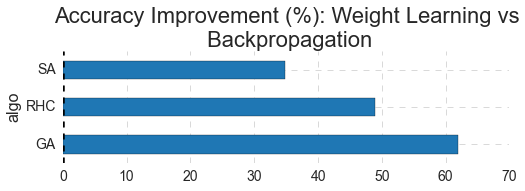

In [25]:
nn.plot_improvement(df_nn, baseline=0.470792365529)

All three algorithms gave an improvement in accuracy when compared to backpropagation algorithm (best = GA (~60%))

#### Optimization Problem #1: Searching for Waldo with "Where is Waldo?" book series

I only recently came across Waldo-spotting book series (since I grew up outside of US) through the blogpost of Randy Olson where he demonstrated optimal search using genetic algorithm. This problem fascinated me by being both fun and illuminating and here I tried to reproduce some of his results using different randomized optimization algorithms.

Problem is approached as a Traveling Salesman Problem - every possible location of where Waldo could be is checked without backtracking. Density visualization of waldo locations based on the 7 books already shows some trends - Waldo is most often found in the lower left corner and upper right. 

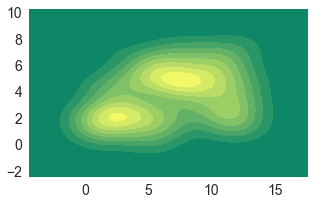

In [28]:
waldo_df = load_waldo_dataset(display=True)

__Fitness Function__: maximimze the negative value of the shortest path.
We need to minimaize the distance between what waldo-looking solutions covers and the real waldo coordinates.

In [26]:
from algo_evaluation.optimization.problems import waldo_optimization as wo

__Compare performance of the four algorithms__

In [29]:
rhc_df, sa_df, ga_df = wo.compare_all(waldo_df)

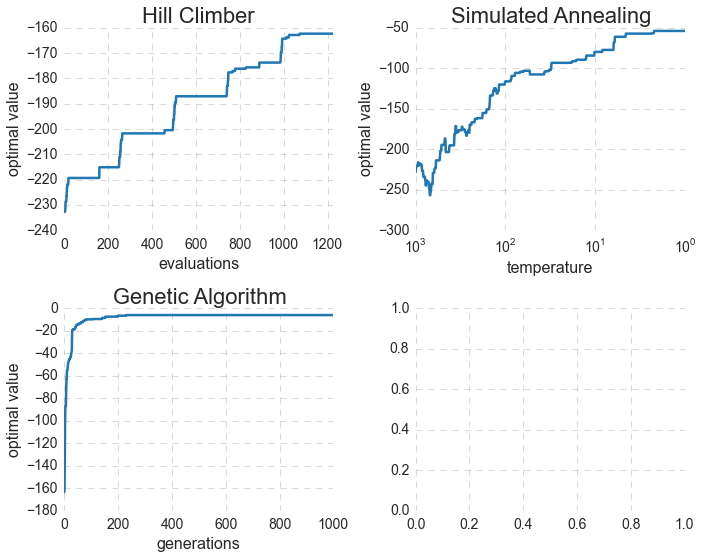

In [30]:
wo.plot_optimal_values(rhc_df, sa_df, ga_df)

Each algorithm demonstrated different behavior specific to the nature of the algorithm.

__Hill Climber__ has very clear equilibria islands during which optimal value was remaining the same. Given enough iterations (10000), the algorithm will converg to the global minimum (in the current scenario algorithm was not getting stuck at the local minimum which is usually typical for RHC).

__Simulated annealing__ was having a hard time finding the optimal path at the begining since it was allowed to accept worse solutions for high temperatures. Notice, that as temperatures cooled down (I have used the log scale for temperatures on x axis to demonstrate more clearly the fact that algorithm stabilized for low temperatures), worse solutions were not accepted any more and algorithm behaved more like RHC.

__Genetic algorithm__ again outperformed the rest of the algorithms since it continuosly tinkers with the solution by slightly mutating the existing best solution until no better solution can be found. Note, that it took a relatively small number of generation to find the optimal path and the improvement in the solution was very rapid (very steep curve).

#### Optimization Problem #2: Automatic Algorithm Configuration

Finding the best fitting classifier for datasets remains an art to be mastered with years of experience. I recently read the paper from the 13th PYTHON IN SCIENCE CONF. (SCIPY 2014) and was thrilled to learn about an ongoing effort developing hyperopt library, which treats the choice of the classifier and pre-processing modules as an optimization problem.  

I have used the idea from the paper to create a mini-optimization problem for the Decision Tree classifier and, fortunatelly, I have a perfect baseline from my previous analysis.

I made the classifier constant while optimizing the parameters fed to the classifier. Naturally, this problem can be extended for varied classifier, however it will suffice for current example.

In [ ]:
from algo_evaluation.optimization.problems import hyper_optimization as ho
reload(ho)

<module 'algo_evaluation.optimization.problems.hyper_optimization' from '/Users/maestro/schoolspace/bag-of-algorithms/algo_evaluation/optimization/problems/hyper_optimization.pyc'>

In [35]:
smaller_higgs_data = load_higgs_train(sample_size=10000)

In [36]:
baseline_accuracy = ho.baseline_dt(smaller_higgs_data)
print 'Decision Tree baseline accuracy (prior to optimizing parameters):', baseline_accuracy

Decision Tree baseline accuracy (prior to optimizing parameters): 0.751823366295


With this optimization problem, I am searching for the best classifier parameters available for tunning (for example, minimum number of samples required to split an internal node and the maximum depth of the tree)

__Fitness Function__: Classifier Accuracy score. 

In [37]:
opt_problem = ho.ClassifierOptimization(smaller_higgs_data)
domain = opt_problem.domain

In [23]:
domain

[(10, 100), (2, 50), (1, 10)]

In [45]:
rhc_2_df = ho.hillclimb(domain, opt_problem.compute_classification_error)

[81, 14, 4]
[82, 14, 4]
[80, 14, 4]
[81, 15, 4]
[81, 13, 4]
[81, 14, 5]
[81, 14, 3]
[81, 15, 4]
[82, 15, 4]
[80, 15, 4]
[81, 16, 4]
[81, 14, 4]
[81, 15, 5]
[81, 15, 3]
[81, 16, 4]
[82, 16, 4]
[80, 16, 4]
[81, 17, 4]
[81, 15, 4]
[81, 16, 5]
[81, 16, 3]
[82, 16, 4]
[83, 16, 4]
[81, 16, 4]
[82, 17, 4]
[82, 15, 4]
[82, 16, 5]
[82, 16, 3]
[81, 16, 4]
[82, 16, 4]
[80, 16, 4]
[81, 17, 4]
[81, 15, 4]
[81, 16, 5]
[81, 16, 3]
[80, 16, 4]
[81, 16, 4]
[79, 16, 4]
[80, 17, 4]
[80, 15, 4]
[80, 16, 5]
[80, 16, 3]
[80, 16, 4]
[81, 16, 4]
[79, 16, 4]
[80, 17, 4]
[80, 15, 4]
[80, 16, 5]
[80, 16, 3]
[81, 16, 4]
[82, 16, 4]
[80, 16, 4]
[81, 17, 4]
[81, 15, 4]
[81, 16, 5]
[81, 16, 3]
[81, 17, 4]
[82, 17, 4]
[80, 17, 4]
[81, 18, 4]
[81, 16, 4]
[81, 17, 5]
[81, 17, 3]
[81, 16, 4]
[82, 16, 4]
[80, 16, 4]
[81, 17, 4]
[81, 15, 4]
[81, 16, 5]
[81, 16, 3]
[82, 16, 4]
[83, 16, 4]
[81, 16, 4]
[82, 17, 4]
[82, 15, 4]
[82, 16, 5]
[82, 16, 3]
[81, 16, 4]
[82, 16, 4]
[80, 16, 4]
[81, 17, 4]
[81, 15, 4]
[81, 16, 5]
[81,

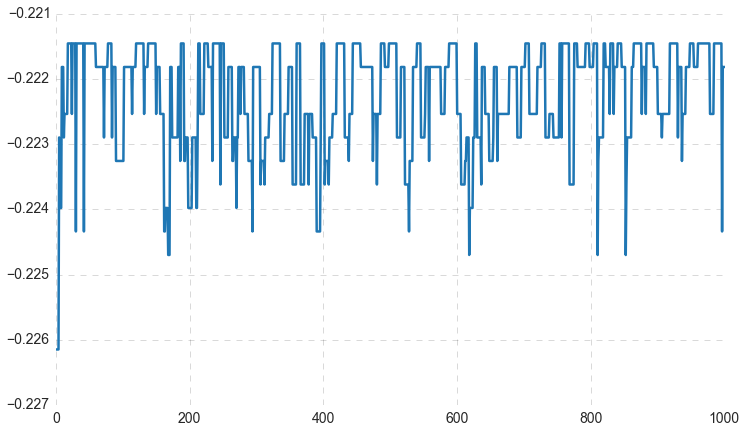

In [41]:
rhc_2_df.optimal_value.plot()

In [42]:
sa_2_df = ho.simulated_annealing(domain, opt_problem.compute_classification_error)

[38.0, 24.0, 5.0]
[38.0, 24.0, 5.0]
[38.0, 24.0, 5.0]
[38.0, 23.0, 5.0]
[38.0, 23.0, 5.0]
[38.0, 22.0, 5.0]
[38.0, 22.0, 5.0]
[37.0, 22.0, 5.0]
[37.0, 22.0, 5.0]
[36.0, 22.0, 5.0]
[36.0, 22.0, 5.0]
[36.0, 22.0, 4.0]
[36.0, 22.0, 4.0]
[35.0, 22.0, 4.0]
[35.0, 22.0, 4.0]
[34.0, 22.0, 4.0]
[34.0, 22.0, 4.0]
[34.0, 21.0, 4.0]
[34.0, 21.0, 4.0]
[35.0, 21.0, 4.0]
[35.0, 21.0, 4.0]
[35.0, 21.0, 5.0]
[35.0, 21.0, 5.0]
[35.0, 21.0, 5.0]
[35.0, 21.0, 5.0]
[36.0, 21.0, 5.0]
[36.0, 21.0, 5.0]
[36.0, 22.0, 5.0]
[36.0, 22.0, 5.0]
[36.0, 22.0, 5.0]
[36.0, 22.0, 5.0]
[36.0, 22.0, 5.0]
[36.0, 22.0, 5.0]
[36.0, 22.0, 5.0]
[36.0, 22.0, 5.0]
[36.0, 21.0, 5.0]
[36.0, 21.0, 5.0]
[36.0, 20.0, 5.0]
[36.0, 20.0, 5.0]
[36.0, 20.0, 5.0]
[36.0, 20.0, 5.0]
[36.0, 20.0, 6.0]
[36.0, 20.0, 6.0]
[37.0, 20.0, 6.0]
[37.0, 20.0, 6.0]
[37.0, 19.0, 6.0]
[37.0, 19.0, 6.0]
[37.0, 18.0, 6.0]
[37.0, 18.0, 6.0]
[37.0, 18.0, 5.0]
[37.0, 18.0, 5.0]
[37.0, 19.0, 5.0]
[37.0, 19.0, 5.0]
[36.0, 19.0, 5.0]
[36.0, 19.0, 5.0]
[36.0, 19.

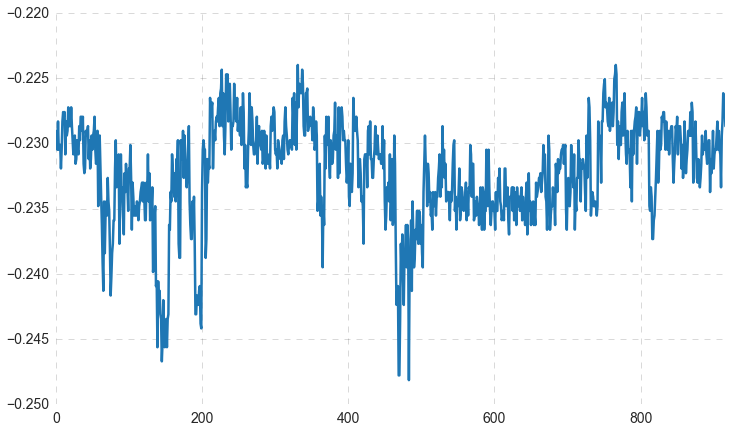

In [43]:
sa_2_df.optimal_value.plot()

In [ ]:
ga_2_df = ho.genetic_optimize(domain, opt_problem.compute_classification_error)

[26, 46, 9]
[65, 48, 10]
[71, 45, 3]
[99, 41, 2]
[31, 38, 8]
[20, 13, 8]
[72, 34, 6]
[67, 37, 10]
[27, 11, 7]
[84, 3, 10]
[10, 21, 8]
[15, 14, 7]
[92, 15, 2]
[43, 48, 8]
[80, 8, 8]
[75, 2, 3]
[20, 29, 9]
[93, 29, 5]
[66, 29, 10]
[43, 9, 3]
[86, 31, 5]
[83, 35, 7]
[18, 42, 5]
[99, 6, 5]
[92, 19, 2]
[16, 18, 6]
[23, 49, 9]
[34, 40, 1]
[69, 14, 8]
[17, 29, 7]
[69, 24, 5]
[82, 17, 6]
[30, 4, 10]
[83, 4, 8]
[100, 27, 2]
[19, 31, 7]
[29, 48, 7]
[32, 21, 8]
[66, 8, 8]
[81, 36, 1]
[11, 30, 2]
[25, 47, 8]
[79, 14, 7]
[70, 13, 3]
[80, 20, 4]
[99, 6, 10]
[100, 9, 5]
[84, 48, 6]
[64, 38, 7]
[45, 31, 6]
[84, 48, 6]
[29, 48, 7]
[43, 48, 8]
[83, 35, 7]
[31, 38, 8]
[64, 38, 7]
[25, 47, 8]
[71, 45, 3]
[18, 42, 5]
[19, 31, 7]
[83, 38, 8]
[64, 48, 8]
[64, 35, 7]
[64, 38, 6]
[64, 38, 8]
[83, 42, 5]
[25, 42, 5]
[64, 45, 3]
[23, 38, 8]
[23, 45, 3]
[71, 38, 8]
[71, 35, 7]
[29, 48, 6]
[18, 48, 7]
[43, 45, 3]
[31, 47, 8]
[83, 48, 6]
[31, 42, 5]
[25, 49, 9]
[83, 45, 3]
[64, 38, 7]
[64, 35, 7]
[43, 48, 7]
[29, 3

In [ ]:
ga_2_df.optimal_value.plot()

In [11]:
rhc_2_df, sa_2_df, ga_2_df = ho.compare_all(smaller_higgs_data)

ValueError: empty range for randrange() (1,1, 0)

In [ ]:
ho.plot_optimal_values(rhc_2_df, sa_2_df, ga_2_df)

### References

[1] Pybrain Optimization Documentation, Online Available, at http://pybrain.org/docs/tutorial/optimization.html

[2] http://www.cc.gatech.edu/~isbell/papers/isbell-mimic-nips-1997.pdf

[3] http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.optimize.anneal.html

[4] http://www.randalolson.com/2015/02/03/heres-waldo-computing-the-optimal-search-strategy-for-finding-waldo/

[5] http://www.math.uwaterloo.ca/tsp/data/ml/monalisa.html

[6] Hyperopt-Sklearn: Automatic Hyperparameter Configuration for Scikit-Learn http://conference.scipy.org/proceedings/scipy2014/pdfs/komer.pdf